In [0]:
!pip install pytrends

In [0]:
import pandas as pd
import numpy as np
import datetime 
import os
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.api as sm

# Data Cleansing to fill missing value

In [0]:
df=pd.read_csv('raw_data/US Mutual Fund Flows.csv')
df['Open'].interpolate(method='linear', inplace=True)
df['Open'].fillna(method='bfill',inplace=True)
df['High'].interpolate(method='linear', inplace=True)
df['High'].fillna(method='bfill',inplace=True)
df['Low'].interpolate(method='linear', inplace=True)
df['Low'].fillna(method='bfill',inplace=True)
df['Close'].interpolate(method='linear', inplace=True)
df['Close'].fillna(method='bfill',inplace=True)
df['Adj Close'].interpolate(method='linear', inplace=True)
df['Adj Close'].fillna(method='bfill',inplace=True)
df.to_csv('merged_data/Mutual.csv', index=False)

In [0]:
df=pd.read_csv('raw_data/US Bond Mutual Fund Flows.csv')
df['Open'].interpolate(method='linear', inplace=True)
df['Open'].fillna(method='bfill',inplace=True)
df['High'].interpolate(method='linear', inplace=True)
df['High'].fillna(method='bfill',inplace=True)
df['Low'].interpolate(method='linear', inplace=True)
df['Low'].fillna(method='bfill',inplace=True)
df['Close'].interpolate(method='linear', inplace=True)
df['Close'].fillna(method='bfill',inplace=True)
df['Adj Close'].interpolate(method='linear', inplace=True)
df['Adj Close'].fillna(method='bfill',inplace=True)
df.to_csv('merged_data/Bond.csv', index=False)

In [0]:
df=pd.read_csv('raw_data/US Equity Mutual Fund Flows.csv')
df['Open'].interpolate(method='linear', inplace=True)
df['Open'].fillna(method='bfill',inplace=True)
df['High'].interpolate(method='linear', inplace=True)
df['High'].fillna(method='bfill',inplace=True)
df['Low'].interpolate(method='linear', inplace=True)
df['Low'].fillna(method='bfill',inplace=True)
df['Close'].interpolate(method='linear', inplace=True)
df['Close'].fillna(method='bfill',inplace=True)
df['Adj Close'].interpolate(method='linear', inplace=True)
df['Adj Close'].fillna(method='bfill',inplace=True)
df.to_csv('merged_data/Equity.csv', index=False)

In [0]:
def update_df2(this_df,df):
    '''
    This function aims to merge two time series into one dataframe
    And it also fill missing dates with extra column
    '''
    try:
        df['date']=pd.to_datetime(df['date'], format='%Y-%m-%d')
    except:
        try:
            df['date']=pd.to_datetime(df['date'], format='%d/%m/%Y')
        except:
            df['date']=pd.to_datetime(df['date'])
    df=df.set_index('date')
    df.index = pd.DatetimeIndex(df.index)
    #remove the duplicated index
    df = df[~df.index.duplicated()]
    df = df.reindex(idx)
    try:
        df=df.drop(['_id'], axis=1)     
    except:
        pass
    
    # merge two data 
    if len(this_df)==0:
        if len(df)!=0:
            this_df=df
    else:
        this_df=pd.concat([this_df,df],axis=1)
    return this_df

# setup necessaty parameter


idx = pd.date_range('2005-01-01', '2020-01-31')


def load_daily_index(path = 'merged_data/',file_name='daily_trends.csv',force_update=False,debug=False):
    csv_files  = []
    xlsx_files = []

    def action1(cache=[]):
        for r, d, f in os.walk(path):
            for file in f:
                if '.csv' in file:
                    csv_files.append(os.path.join(r, file))
                if '.xlsx' in file:
                    xlsx_files.append(os.path.join(r, file))
        # concate and merge all the dataframes
        for file in csv_files:
            if debug==True:
                print('\r'+file,end='')
            df=pd.read_csv(file).iloc[:,[0,5]]
            cache = update_df2(cache,df)

        for file in xlsx_files:
            df=pd.read_excel(file).iloc[:,[0,5]]
            cache = update_df2(cache,df)
        # save daily data to one csv
        cache.to_csv('merged_data/'+file_name)
        return cache
    
    if force_update == False:
        try:
            this_df = pd.read_csv('merged_data/'+file_name,index_col=0)
        except:
            this_df = action1()
    else:
        this_df = action1()
    return this_df

In [0]:
# this is the 30 words that is shown by the paper
daily_trends=load_daily_index(force_update=False)
daily_trends.index = pd.DatetimeIndex(daily_trends.index)

In [0]:
daily_trends = daily_trends.replace({0:1})  # replace 0 search with 1 to avoid problem
return_ratio = np.log(daily_trends.iloc[1:,:])-np.log(daily_trends.iloc[:-1,:].values)
for column in list(return_ratio):   
    return_ratio.loc[:,column] = scipy.stats.mstats.winsorize(return_ratio.loc[:,column].values, limits=[0.05, 0.05])

### Now remove the seasonality

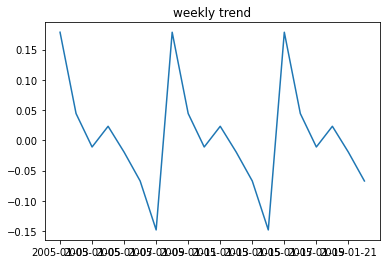

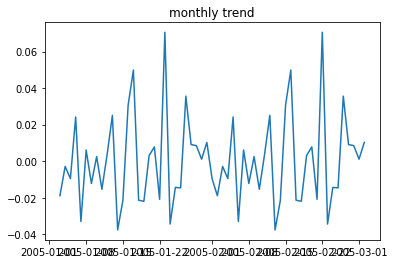

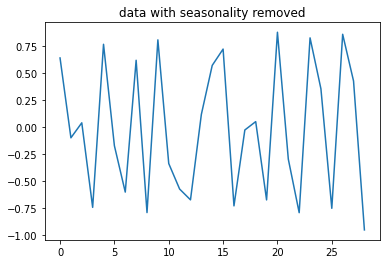

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose

data = return_ratio.loc[:,'PRICE OF GOLD']
weekly = seasonal_decompose(data, freq=7)
plt.plot(weekly.seasonal[1:21])
plt.title('weekly trend')
plt.show()
data = data - weekly.seasonal
monthly = seasonal_decompose(data, freq=30)
data = data - monthly.seasonal


plt.plot(monthly.seasonal[1:60])
plt.title('monthly trend')
plt.show()

plt.plot(data.values[1:30])
plt.title('data with seasonality removed')
plt.show()



def remove_seasonality(data):
    weekly = seasonal_decompose(data, freq=7)
    r = data - weekly.seasonal
    monthly = seasonal_decompose(r, freq=30)
    r = r - monthly.seasonal
    return r

# remove seasonality on weekly and monthly dummy, and standardized by scaling each on standard deviation
original_return = return_ratio.copy()
for column in list(return_ratio):   
    return_ratio.loc[:,column] = remove_seasonality(return_ratio.loc[:,column])
    return_ratio.loc[:,column] /= np.std(return_ratio.loc[:,column].values)

In [0]:
return_ratio['fears_index'] = return_ratio.sum(axis=1)/30
original_return['fears_index'] = original_return.sum(axis=1)/30

## Step 2: construct all other relevant data

In [0]:
Mutual=pd.read_csv('merged_data/Mutual.csv').iloc[:,[0,4]]
Mutual['Date']=pd.to_datetime(Mutual['Date'], format='%Y-%m-%d')
Mutual=Mutual.set_index('Date')
Mutual.columns=['Mutual']
Mutual = np.log(Mutual.iloc[1:,:])-np.log(Mutual.iloc[:-1,:].values)

Equity=pd.read_csv('merged_data/Equity.csv').iloc[:,[0,4]]
Equity['Date']=pd.to_datetime(Equity['Date'], format='%Y-%m-%d')
Equity=Equity.set_index('Date')
Equity.columns=['Equity']
Equity = np.log(Equity.iloc[1:,:])-np.log(Equity.iloc[:-1,:].values)

Bond=pd.read_csv('merged_data/Bond.csv').iloc[:,[0,4]]
Bond['Date']=pd.to_datetime(Bond['Date'], format='%Y-%m-%d')
Bond=Bond.set_index('Date')
Bond.columns=['Bond']
Bond = np.log(Bond.iloc[1:,:])-np.log(Bond.iloc[:-1,:].values)

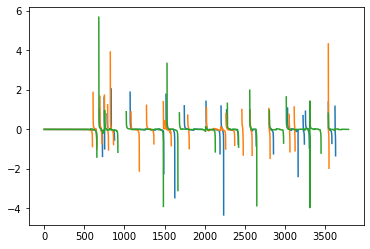

In [17]:
plt.plot(Mutual.values)
plt.plot(Equity.values)
plt.plot(Bond.values)

In [0]:
EPU=pd.read_excel('merged_data/All_Daily_Policy_Data.xlsx')
EPU['Date']=pd.to_datetime(EPU['Date'], format='%d/%m/%Y')
EPU = EPU.set_index('Date')
EPU.columns=['EPU']
EPU = np.log(EPU.iloc[1:,:])-np.log(EPU.iloc[:-1,:].values)

ADS=pd.read_excel('merged_data/ADS_Index_Most_Current_Vintage.xlsx',index_col=0)
ADS.columns=['ADS']
ADS = (ADS.iloc[1:,:]-ADS.iloc[:-1,:].values).divide(ADS.iloc[:-1,:].values)

VIX = pd.read_csv('merged_data/vixcurrent.csv').iloc[:,[0,4]]
VIX['Date']=pd.to_datetime(VIX['Date'], format='%m/%d/%Y')
VIX = VIX.set_index('Date')
VIX.columns=['VIX']
VIX = np.log(VIX.iloc[1:,:])-np.log(VIX.iloc[:-1,:].values)

## Step 3: construct dynamic Fears index selecting from 120 words and with variable updating frequency

### in the paper, the author worked with updating frequency of 6 months, but we could do better than that  :-)
### I put this step here because I need the SPY data to do regression in order to update FEARS index components.

In [0]:
# first read the data
all_daily_trends = load_daily_index(path = '111_google_trend/',file_name='111_daily_trends.csv', force_update=False,debug=True)
all_daily_trends = all_daily_trends.loc[:,(all_daily_trends.isna().sum()<100).values]  # remove column with too many missing value

In [0]:
all_daily_trends = all_daily_trends.replace({0:1})  # replace 0 search with 1 to avoid problem
all_return_ratio = np.log(all_daily_trends.iloc[1:,:])-np.log(all_daily_trends.iloc[:-1,:].values)

for column in list(all_return_ratio):              
    # winsorize data
    all_return_ratio.loc[:,column] = scipy.stats.mstats.winsorize(all_return_ratio.loc[:,column].values, limits=[0.05, 0.05])
    # remove seasonality
    all_return_ratio.loc[:,column] = remove_seasonality(all_return_ratio.loc[:,column])
    # removeheteroscedasticity
    all_return_ratio.loc[:,column] /= np.std(all_return_ratio.loc[:,column].values)
all_return_ratio.index = pd.DatetimeIndex(all_return_ratio.index)

In [0]:
def create_dynamic_index_Mutual(frequency,all_return_ratio,Mutual):
    all_return_with_Fears = all_return_ratio.copy()
    start_date = pd.Timestamp(year=2005, month=1, day=2).date()
    end_date = start_date + pd.Timedelta(frequency*30,unit='D')
    next_end_date = end_date + pd.Timedelta(frequency*30,unit='D')


    while next_end_date<pd.Timestamp(year=2020, month=1, day=30).date():
        print('\r now end time is '+str(end_date),end='')
        # seperate the dataset into several time segements 
        selected_data = all_return_ratio.loc[pd.date_range(start_date,end_date),:]

        # includes return data
        word_choices = list(selected_data)
        selected_data_Mutual = selected_data.join(Mutual,how='inner')
        ranking = []

        # run regression on all 104 words within this selected periods
        for word in word_choices:
            X = sm.add_constant(selected_data_Mutual.loc[:,[word]])
            model = sm.OLS(selected_data_Mutual.loc[:,['Mutual']], X).fit()   # run regression
            t_stats = pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]['t'][1]
            ranking.append([t_stats,word])    # save word and t statistics

        # select the 30 most negative words
        ranking.sort()
        negative_30_words = [ranking[i][1] for i in range(30)] 
        this_fears_index = selected_data.loc[:,negative_30_words].sum(axis=1)/30

        # update the fears index
        all_return_with_Fears.loc[(all_return_with_Fears.index>=pd.Timestamp(end_date)) & (all_return_with_Fears.index<=pd.Timestamp(next_end_date)),'FEARS'] = this_fears_index.values
        start_date = end_date
        end_date = next_end_date
        next_end_date = next_end_date + pd.Timedelta(frequency*30,unit='D')
    Fears_index = all_return_with_Fears.loc[all_return_with_Fears.FEARS.isna()!=True,['FEARS']]
    return Fears_index

In [0]:
def create_dynamic_index_Equity(frequency,all_return_ratio,Equity):
    all_return_with_Fears = all_return_ratio.copy()
    start_date = pd.Timestamp(year=2005, month=1, day=2).date()
    end_date = start_date + pd.Timedelta(frequency*30,unit='D')
    next_end_date = end_date + pd.Timedelta(frequency*30,unit='D')


    while next_end_date<pd.Timestamp(year=2020, month=1, day=30).date():
        print('\r now end time is '+str(end_date),end='')
        # seperate the dataset into several time segements 
        selected_data = all_return_ratio.loc[pd.date_range(start_date,end_date),:]

        # includes return data
        word_choices = list(selected_data)
        selected_data_Equity = selected_data.join(Equity,how='inner')
        ranking = []

        # run regression on all 104 words within this selected periods
        for word in word_choices:
            X = sm.add_constant(selected_data_Equity.loc[:,[word]])
            model = sm.OLS(selected_data_Equity.loc[:,['Equity']], X).fit()   # run regression
            t_stats = pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]['t'][1]
            ranking.append([t_stats,word])    # save word and t statistics

        # select the 30 most negative words
        ranking.sort()
        negative_30_words = [ranking[i][1] for i in range(30)] 
        this_fears_index = selected_data.loc[:,negative_30_words].sum(axis=1)/30

        # update the fears index
        all_return_with_Fears.loc[(all_return_with_Fears.index>=pd.Timestamp(end_date)) & (all_return_with_Fears.index<=pd.Timestamp(next_end_date)),'FEARS'] = this_fears_index.values
        start_date = end_date
        end_date = next_end_date
        next_end_date = next_end_date + pd.Timedelta(frequency*30,unit='D')
    Fears_index = all_return_with_Fears.loc[all_return_with_Fears.FEARS.isna()!=True,['FEARS']]
    return Fears_index

In [0]:
def create_dynamic_index_Bond(frequency,all_return_ratio,Bond):
    all_return_with_Fears = all_return_ratio.copy()
    start_date = pd.Timestamp(year=2005, month=1, day=2).date()
    end_date = start_date + pd.Timedelta(frequency*30,unit='D')
    next_end_date = end_date + pd.Timedelta(frequency*30,unit='D')


    while next_end_date<pd.Timestamp(year=2020, month=1, day=30).date():
        print('\r now end time is '+str(end_date),end='')
        # seperate the dataset into several time segements 
        selected_data = all_return_ratio.loc[pd.date_range(start_date,end_date),:]

        # includes return data
        word_choices = list(selected_data)
        selected_data_Bond = selected_data.join(Bond,how='inner')
        ranking = []

        # run regression on all 104 words within this selected periods
        for word in word_choices:
            X = sm.add_constant(selected_data_Bond.loc[:,[word]])
            model = sm.OLS(selected_data_Bond.loc[:,['Bond']], X).fit()   # run regression
            t_stats = pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]['t'][1]
            ranking.append([t_stats,word])    # save word and t statistics

        # select the 30 most negative words
        ranking.sort()
        negative_30_words = [ranking[i][1] for i in range(30)] 
        this_fears_index = selected_data.loc[:,negative_30_words].sum(axis=1)/30

        # update the fears index
        all_return_with_Fears.loc[(all_return_with_Fears.index>=pd.Timestamp(end_date)) & (all_return_with_Fears.index<=pd.Timestamp(next_end_date)),'FEARS'] = this_fears_index.values
        start_date = end_date
        end_date = next_end_date
        next_end_date = next_end_date + pd.Timedelta(frequency*30,unit='D')
    Fears_index = all_return_with_Fears.loc[all_return_with_Fears.FEARS.isna()!=True,['FEARS']]
    return Fears_index

In [47]:
Fears_index_Mutual = create_dynamic_index_Mutual(6, all_return_ratio,Mutual)

 now end time is 2005-07-01

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1708: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.6/dist-packages/statsmodels/stats/stattools.py:46: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastruc

 now end time is 2019-04-19

In [51]:
Fears_index_Equity = create_dynamic_index_Equity(6, all_return_ratio,Equity)

 now end time is 2005-07-01

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1708: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.6/dist-packages/statsmodels/stats/stattools.py:46: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastruc

 now end time is 2019-04-19

In [52]:
Fears_index_Bond = create_dynamic_index_Bond(6, all_return_ratio,Bond)

 now end time is 2005-07-01

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1708: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/usr/local/lib/python3.6/dist-packages/statsmodels/stats/stattools.py:46: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastruc

 now end time is 2019-04-19

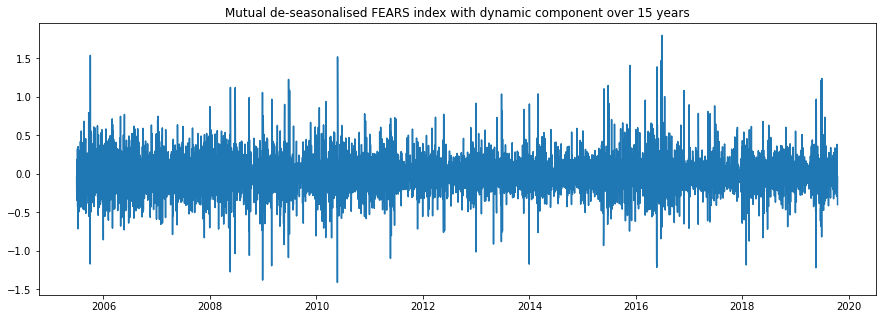

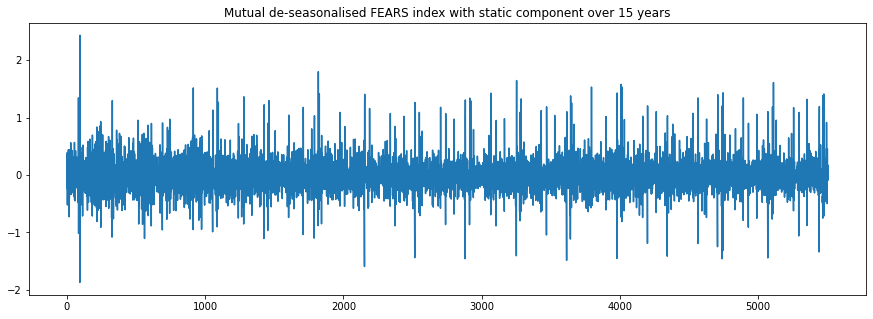

In [48]:
plt.figure(figsize=(15,5))
plt.plot(Fears_index_Mutual)
plt.title('Mutual de-seasonalised FEARS index with dynamic component over 15 years')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(return_ratio.fears_index.values)
plt.title('Mutual de-seasonalised FEARS index with static component over 15 years')
plt.show()

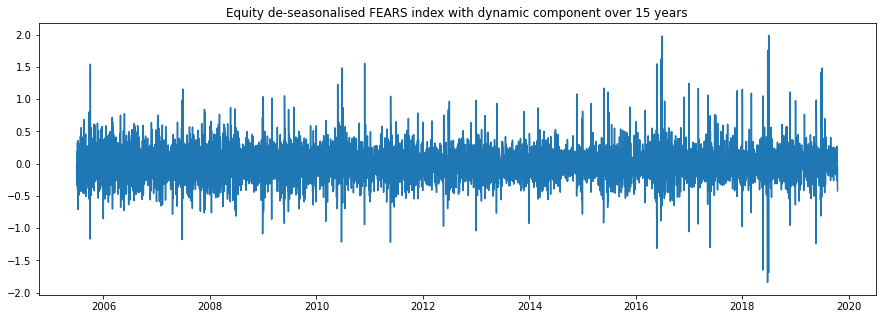

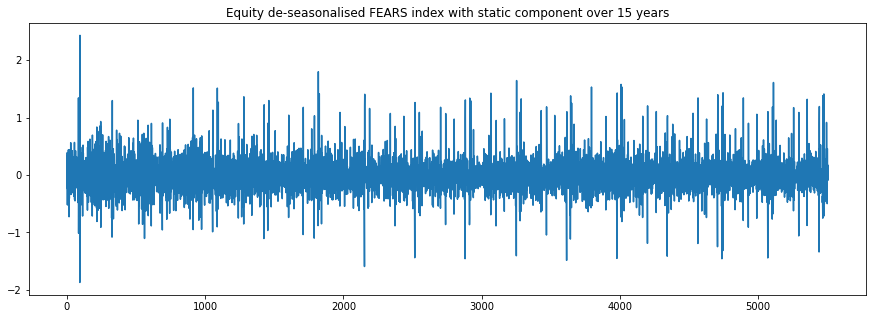

In [53]:
plt.figure(figsize=(15,5))
plt.plot(Fears_index_Equity)
plt.title('Equity de-seasonalised FEARS index with dynamic component over 15 years')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(return_ratio.fears_index.values)
plt.title('Equity de-seasonalised FEARS index with static component over 15 years')
plt.show()

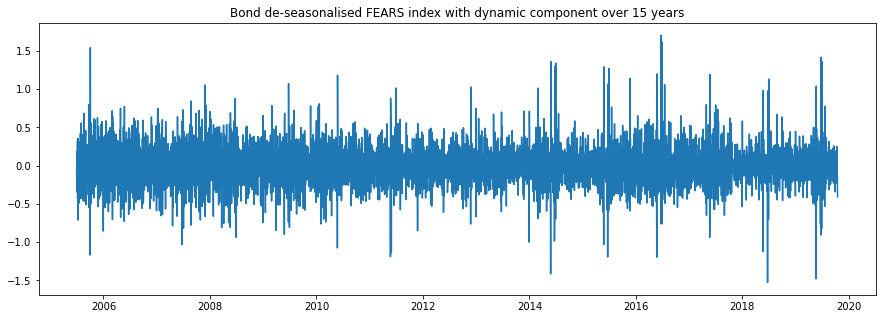

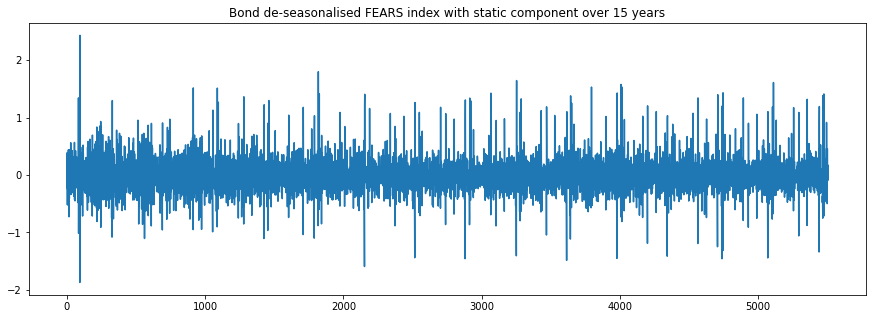

In [54]:
plt.figure(figsize=(15,5))
plt.plot(Fears_index_Bond)
plt.title('Bond de-seasonalised FEARS index with dynamic component over 15 years')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(return_ratio.fears_index.values)
plt.title('Bond de-seasonalised FEARS index with static component over 15 years')
plt.show()

## US Mutual Fund Flows

In [49]:
merged_data= Mutual.join(EPU,how='inner')
merged_data= merged_data.join(ADS,how='inner')
merged_data= merged_data.join(VIX,how='inner')
merged_data= merged_data.join(return_ratio.fears_index,how='inner')
merged_data= merged_data.join(Fears_index_Mutual,how='inner').rename(columns={'fears_index':'static_fears','FEARS':'6month_dynamic_fears'})
merged_data.head()
merged_data.to_csv('merged_data/final_data.csv')
print(len(merged_data))

3598


In [50]:
start = 0
end = 3200-5
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 

trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+5):(end),0].values, X).fit()
print('Ret(t)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t)
                          coef       t  P>|t|
const                 0.000039   0.039  0.969
EPU                   0.003700   1.906  0.057
ADS                  -0.000300  -0.220  0.826
VIX                  -0.028000  -2.086  0.037
6month_dynamic_fears  0.000700   0.171  0.864
t-1                   0.427900  24.163  0.000
t-2                   0.109000   5.668  0.000
t-3                   0.054700   2.835  0.005
t-4                   0.034800   1.808  0.071
t-5                   0.034600   1.957  0.050
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.299


In [55]:
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 

trained_data.loc[:,'t'] = merged_data.iloc[(start+5):end,0].values
trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+6):(end+1),0].values, X).fit()

print('Ret(t+1)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t+1)
                        coef       t  P>|t|
const                -0.0003  -0.287  0.774
EPU                  -0.0030  -1.575  0.115
ADS                  -0.0009  -0.639  0.523
VIX                  -0.0140  -1.041  0.298
6month_dynamic_fears -0.0031  -0.806  0.420
t                     0.4258  24.004  0.000
t-1                   0.1085   5.631  0.000
t-2                   0.0532   2.749  0.006
t-3                   0.0325   1.682  0.093
t-4                   0.0246   1.278  0.201
t-5                   0.0239   1.349  0.177
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.298


In [56]:
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 
trained_data.loc[:,'t'] = merged_data.iloc[(start+5):end,0].values
trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+7):(end+2),0].values, X).fit()

print('Ret(t+2)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t+2)
                        coef       t  P>|t|
const                -0.0002  -0.207  0.836
EPU                  -0.0007  -0.324  0.746
ADS                  -0.0012  -0.746  0.456
VIX                  -0.0053  -0.364  0.716
6month_dynamic_fears -0.0030  -0.724  0.469
t                     0.2893  15.003  0.000
t-1                   0.0987   4.711  0.000
t-2                   0.0548   2.604  0.009
t-3                   0.0359   1.706  0.088
t-4                   0.0268   1.278  0.201
t-5                   0.0271   1.405  0.160
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.171


In [57]:
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 
trained_data.loc[:,'t'] = merged_data.iloc[(start+5):end,0].values
trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+8):(end+3),0].values, X).fit()

print('Ret(t+3)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t+3)
                        coef       t  P>|t|
const                -0.0005  -0.445  0.656
EPU                  -0.0027  -1.243  0.214
ADS                   0.0063   3.846  0.000
VIX                   0.0071   0.474  0.635
6month_dynamic_fears -0.0014  -0.336  0.737
t                     0.2228  11.195  0.000
t-1                   0.0844   3.901  0.000
t-2                   0.0506   2.329  0.020
t-3                   0.0344   1.584  0.113
t-4                   0.0270   1.247  0.212
t-5                   0.0259   1.302  0.193
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.117


#US Bond Mutual Fund Flows

In [63]:
merged_data= Bond.join(EPU,how='inner')
merged_data= merged_data.join(ADS,how='inner')
merged_data= merged_data.join(VIX,how='inner')
merged_data= merged_data.join(return_ratio.fears_index,how='inner')
merged_data= merged_data.join(Fears_index_Equity,how='inner').rename(columns={'fears_index':'static_fears','FEARS':'6month_dynamic_fears'})
merged_data.head()
merged_data.to_csv('merged_data/final_data.csv')
print(len(merged_data))

3598


In [64]:
start = 0
end = 3200-5
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 

trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+5):(end),0].values, X).fit()
print('Ret(t)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t)
                        coef      t  P>|t|
const                -0.0004 -0.252  0.801
EPU                   0.0005  0.161  0.872
ADS                  -0.0004 -0.163  0.870
VIX                  -0.0390 -1.715  0.087
6month_dynamic_fears -0.0042 -0.644  0.520
t-1                   0.1242  7.002  0.000
t-2                   0.0864  4.836  0.000
t-3                   0.0552  3.082  0.002
t-4                   0.0381  2.130  0.033
t-5                   0.0287  1.618  0.106
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.037


In [65]:
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 

trained_data.loc[:,'t'] = merged_data.iloc[(start+5):end,0].values
trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+6):(end+1),0].values, X).fit()

print('Ret(t+1)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t+1)
                        coef      t  P>|t|
const                -0.0005 -0.269  0.788
EPU                  -0.0002 -0.064  0.949
ADS                  -0.0002 -0.094  0.925
VIX                  -0.0426 -1.869  0.062
6month_dynamic_fears  0.0019  0.290  0.772
t                     0.1239  6.989  0.000
t-1                   0.0837  4.683  0.000
t-2                   0.0545  3.039  0.002
t-3                   0.0370  2.062  0.039
t-4                   0.0269  1.507  0.132
t-5                   0.0204  1.146  0.252
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.037


In [66]:
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 
trained_data.loc[:,'t'] = merged_data.iloc[(start+5):end,0].values
trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+7):(end+2),0].values, X).fit()

print('Ret(t+2)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t+2)
                        coef      t  P>|t|
const                -0.0004 -0.229  0.819
EPU                   0.0017  0.512  0.609
ADS                  -0.0001 -0.060  0.952
VIX                   0.0477  2.080  0.038
6month_dynamic_fears  0.0015  0.237  0.813
t                     0.1014  5.678  0.000
t-1                   0.0654  3.633  0.000
t-2                   0.0414  2.295  0.022
t-3                   0.0294  1.629  0.103
t-4                   0.0215  1.196  0.232
t-5                   0.0161  0.899  0.369
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.023


In [67]:
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 
trained_data.loc[:,'t'] = merged_data.iloc[(start+5):end,0].values
trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+8):(end+3),0].values, X).fit()

print('Ret(t+3)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t+3)
                        coef      t  P>|t|
const                -0.0006 -0.349  0.727
EPU                  -0.0014 -0.410  0.682
ADS                   0.0005  0.202  0.840
VIX                   0.0543  2.357  0.018
6month_dynamic_fears  0.0057  0.861  0.389
t                     0.0778  4.336  0.000
t-1                   0.0522  2.883  0.004
t-2                   0.0337  1.856  0.064
t-3                   0.0240  1.326  0.185
t-4                   0.0178  0.984  0.325
t-5                   0.0128  0.712  0.477
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.014


#US Equity Mutual Fund Flows

In [58]:
merged_data= Equity.join(EPU,how='inner')
merged_data= merged_data.join(ADS,how='inner')
merged_data= merged_data.join(VIX,how='inner')
merged_data= merged_data.join(return_ratio.fears_index,how='inner')
merged_data= merged_data.join(Fears_index_Equity,how='inner').rename(columns={'fears_index':'static_fears','FEARS':'6month_dynamic_fears'})
merged_data.head()
merged_data.to_csv('merged_data/final_data.csv')
print(len(merged_data))

3598


In [59]:
start = 0
end = 3200-5
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 

trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+5):(end),0].values, X).fit()
print('Ret(t)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t)
                          coef       t  P>|t|
const                -0.000300  -0.322  0.748
EPU                  -0.002500  -1.309  0.191
ADS                   0.000015   0.010  0.992
VIX                  -0.001900  -0.140  0.888
6month_dynamic_fears  0.010100   2.619  0.009
t-1                   0.311400  17.598  0.000
t-2                   0.127200   6.872  0.000
t-3                   0.071400   3.839  0.000
t-4                   0.051600   2.788  0.005
t-5                   0.045400   2.566  0.010
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.205


In [60]:
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 

trained_data.loc[:,'t'] = merged_data.iloc[(start+5):end,0].values
trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+6):(end+1),0].values, X).fit()

print('Ret(t+1)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t+1)
                          coef       t  P>|t|
const                 0.000061   0.061  0.952
EPU                   0.003100   1.589  0.112
ADS                  -0.000500  -0.311  0.756
VIX                   0.008200   0.608  0.543
6month_dynamic_fears -0.009900  -2.574  0.010
t                     0.312600  17.638  0.000
t-1                   0.124800   6.736  0.000
t-2                   0.069500   3.727  0.000
t-3                   0.046700   2.508  0.012
t-4                   0.033900   1.828  0.068
t-5                   0.033900   1.916  0.055
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.206


In [61]:
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 
trained_data.loc[:,'t'] = merged_data.iloc[(start+5):end,0].values
trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+7):(end+2),0].values, X).fit()

print('Ret(t+2)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t+2)
                        coef       t  P>|t|
const                -0.0002  -0.149  0.882
EPU                  -0.0001  -0.062  0.950
ADS                  -0.0006  -0.380  0.704
VIX                   0.0227   1.609  0.108
6month_dynamic_fears -0.0085  -2.119  0.034
t                     0.2222  11.978  0.000
t-1                   0.1073   5.533  0.000
t-2                   0.0654   3.349  0.001
t-3                   0.0466   2.387  0.017
t-4                   0.0356   1.837  0.066
t-5                   0.0359   1.936  0.053
                   0     1
5  No. Observations:  3190
                 2     3
1  Adj. R-squared:  0.13


In [62]:
trained_data = merged_data.iloc[(start+5):end,[0,1,2,3,5]].copy() 
trained_data.loc[:,'t'] = merged_data.iloc[(start+5):end,0].values
trained_data.loc[:,'t-1'] = merged_data.iloc[(start+4):(end-1),0].values
trained_data.loc[:,'t-2'] = merged_data.iloc[(start+3):(end-2),0].values
trained_data.loc[:,'t-3'] = merged_data.iloc[(start+2):(end-3),0].values
trained_data.loc[:,'t-4'] = merged_data.iloc[(start+1):(end-4),0].values
trained_data.loc[:,'t-5'] = merged_data.iloc[start:(end-5),0].values

X = sm.add_constant(trained_data.iloc[:,1:])
model = sm.OLS(merged_data.iloc[(start+8):(end+3),0].values, X).fit()

print('Ret(t+3)')
print(pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0].loc[:,['coef','t','P>|t|']])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[5],[0,1]])
print(pd.read_html(model.summary().tables[0].as_html())[0].iloc[[1],[2,3]])

Ret(t+3)
                          coef      t  P>|t|
const                 0.000013  0.012  0.990
EPU                   0.003700  1.796  0.073
ADS                  -0.000500 -0.340  0.734
VIX                   0.028200  1.961  0.050
6month_dynamic_fears -0.006200 -1.514  0.130
t                     0.176600  9.320  0.000
t-1                   0.091800  4.638  0.000
t-2                   0.059600  2.991  0.003
t-3                   0.043800  2.200  0.028
t-4                   0.033600  1.695  0.090
t-5                   0.034800  1.838  0.066
                   0     1
5  No. Observations:  3190
                 2      3
1  Adj. R-squared:  0.093
